The SK model:
### Sherrington–Kirkpatrick (SK) Spin Glass Model

The Hamiltonian of the Sherrington–Kirkpatrick model is

$$
\mathcal{H}_N(\boldsymbol{\sigma})
= - \sum_{1 \le i < j \le N} J_{ij}\,\sigma_i \sigma_j
\;-\;
\sum_{i=1}^{N} h_i\,\sigma_i ,
$$

where the terms are defined as follows:

- $\sigma_i \in \{+1,-1\}$ are **Ising spins**, representing binary degrees of freedom.
- $J_{ij}$ are **quenched random couplings** between spins $i$ and $j$, drawn independently from a Gaussian distribution
  $$
  J_{ij} \sim \mathcal{N}\!\left(0,\frac{J^2}{N}\right),
  $$
  often with $J^2 = 1$.
- The scaling $1/N$ ensures a **well-defined thermodynamic limit**, so that the total energy is extensive (of order $N$).
- $h_i$ is an **external field** acting on spin $i$ (often taken as $h_i = h$ or $h_i = 0$).
- The first term encodes **frustrated interactions** due to random signs of $J_{ij}$.
- The second term biases spins toward alignment with the external field.

The SK model is a **mean-field spin glass**, meaning every spin interacts with every other spin with random strength.


### The Transformer architecture and its components

### High-level Thesis Vision

This thesis investigates a two-way bridge between spin glass theory and transformer models:

Forward direction (Goal I):
Use transformers as learned statistical models to approximate and simulate equilibrium properties of spin glasses.

Reverse direction (Goal II):
Use spin-glass concepts (overlaps, Gibbs measures, replica symmetry breaking, free energy) to develop new tools for interpretability and intervention in transformers.

The unifying idea is that both systems are large, high-dimensional, disordered systems whose macroscopic behavior is better described by distributions over states than by individual parameters.

Goal 1 : do MCMC sampling to generate the data which will train the transformer, see if QKD dot product is closest to normalized h_eff_i ( which is the effective field acting on spin i due to the configuration from other spins  its normalized version give you P ( sigma_i given rest of the configuration)), How accurately does it predict ground state properties such as free Energy, magnetization etc )
h_eff can be calculated directly for small N 

Attention is simply normalized dot product , probability of sigma_i given config is normalized h_eff times some constant, so they have to be analgous 

Goal 2: Can Spin Glass ideas such as ultrametricity, Replica Symmetry Breaking , TAP equations, cavity method, improve interpretability and intervenability in Transformers. 

### Goal 1:

Using device: cuda

===== N = 10 =====
  beta = 5
Spearman = -0.074428 | 
  beta = 10
Spearman = -1.000000 | 
  beta = 15


C:\Users\Acer\AppData\Local\Temp\ipykernel_12444\4272045169.py:166: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman, p_value = spearmanr(h_vals, qk_sum_vals)


Spearman = nan | 
  beta = 19
Spearman = nan | 

===== N = 30 =====
  beta = 5
Spearman = -0.063100 | 
  beta = 10
Spearman = -0.952254 | 
  beta = 15
Spearman = nan | 
  beta = 19
Spearman = 1.000000 | 

===== N = 50 =====
  beta = 5
Spearman = 0.207643 | 
  beta = 10
Spearman = -0.993712 | 
  beta = 15
Spearman = 0.036572 | 
  beta = 19
Spearman = nan | 

===== N = 70 =====
  beta = 5
Spearman = -0.728812 | 
  beta = 10
Spearman = -0.112261 | 
  beta = 15
Spearman = -0.998153 | 
  beta = 19
Spearman = 0.923467 | 

===== N = 90 =====
  beta = 5
Spearman = -0.299523 | 
  beta = 10
Spearman = 0.310345 | 
  beta = 15
Spearman = 0.998216 | 
  beta = 19
Spearman = 0.029238 | 
min(h) = -0.9106037616729736 max(h) = -0.5458365082740784 std(h) = 0.1218211457651862
min(h) = -0.9106037616729736 max(h) = -0.5458365082740784 std(h) = 0.1218211457651862
min(h) = -0.9106037616729736 max(h) = -0.5458365082740784 std(h) = 0.1218211457651862
min(h) = -0.9106037616729736 max(h) = -0.5458365082740784 std

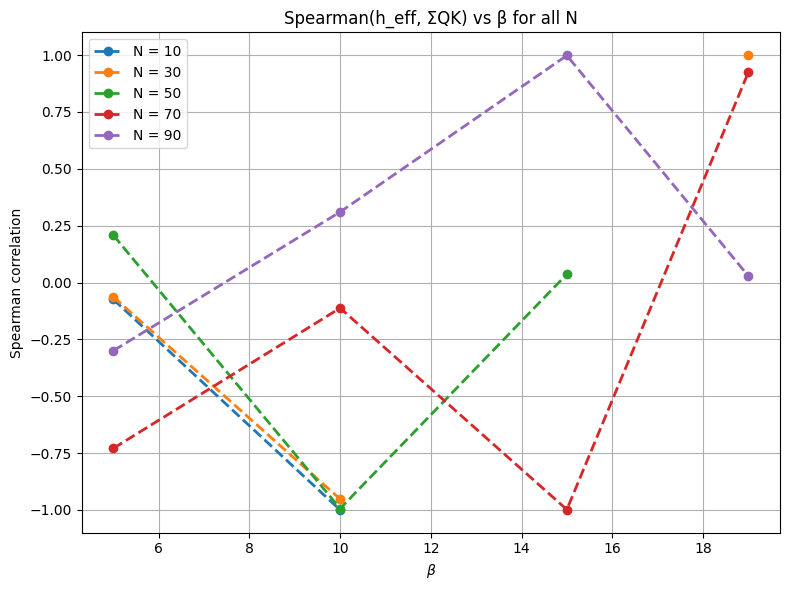

In [3]:
# ============================================================
# Spin Glass ↔ Transformer Raw-QK Alignment Experiment
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ============================================================
# DEVICE
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# METROPOLIS SAMPLER (SK MODEL)
# ============================================================

def metropolis_step(sigma, J, beta):
    i = random.randrange(len(sigma))
    h_eff_i = torch.dot(J[i], sigma)
    delta_E = 2 * sigma[i] * h_eff_i
    if delta_E <= 0 or random.random() < math.exp(-beta * delta_E):
        sigma[i] *= -1
    return sigma


def sample_equilibrium(J, beta, steps=12000, burn_in=4000, thinning=20):
    N = J.shape[0]
    sigma = (torch.randint(0, 2, (N,), device=device) * 2 - 1).float()
    samples = []
    for t in range(steps):
        sigma = metropolis_step(sigma, J, beta)
        if t > burn_in and t % thinning == 0:
            samples.append(sigma.clone())
    return torch.stack(samples)

# ============================================================
# TRANSFORMER
# ============================================================

class SpinTransformer(nn.Module):
    def __init__(self, d_model=64):
        super().__init__()
        self.embed = nn.Linear(1, d_model)
        self.attn = nn.MultiheadAttention(d_model, 1, batch_first=True)
        self.ff = nn.Linear(d_model, d_model)
        self.classifier = nn.Linear(d_model, 2)

    def forward(self, x):
        x = self.embed(x.unsqueeze(-1))
        attn_out, _ = self.attn(x, x, x)
        delta = attn_out - x
        delta -= delta.mean(dim=1, keepdim=True)
        x = x + delta
        x = self.ff(x)
        return self.classifier(x)

# ============================================================
# PARAMETERS
# ============================================================

N_values = [10, 30, 50, 70, 90]
beta_values = [5,10,15,19]  # Phase transition seems to occur at approx 20 as Spearman starts throwing nans, the effective field values become constnat



batch_size = 128
lr = 1e-3
SITE = 5         # Might need average over all sites 

results = {}

# ============================================================
# MAIN EXPERIMENT
# ============================================================

for N in N_values:
    epochs = int(5 * N)
   
    print(f"\n===== N = {N} =====")
    results[N] = []

    J = torch.randn(N, N, device=device) / math.sqrt(N)
    J = (J + J.T) / 2
    J.fill_diagonal_(0)

    for beta in beta_values:
        print(f"  beta = {beta}")

        samples = sample_equilibrium(J, beta)

        # dataset
        X, Y = [], []
        for s in samples:
            x = s.clone()
            y = s[SITE]
            x[SITE] = 0.0
            X.append(x)
            Y.append(0 if y == -1 else 1)

        X = torch.stack(X).to(device)
        Y = torch.tensor(Y, device=device)

        model = SpinTransformer().to(device)
        opt = optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        # training
        for _ in range(epochs):
            perm = torch.randperm(len(X))
            for k in range(0, len(X), batch_size):
                idx = perm[k:k + batch_size]
                logits = model(X[idx])[:, SITE]
                loss = loss_fn(logits, Y[idx])
                opt.zero_grad()
                loss.backward()
                opt.step()

        # ====================================================
        # MEASUREMENTS: h_eff vs RAW QK
        # ====================================================

        h_vals = []
        qk_sum_vals = []
        pairwise_corrs = []

        with torch.no_grad():
            for sigma in samples[:60]:
                sigma = sigma.to(device)

                # physics
                h_i = torch.dot(J[SITE], sigma)
                h_vals.append(h_i.item())
                phys_pairwise = J[SITE] * sigma
                phys_pairwise[SITE] = 0.0

                # transformer internals
                x = model.embed(sigma.unsqueeze(0).unsqueeze(-1))
                d = model.attn.embed_dim
                W = model.attn.in_proj_weight
                W_Q, W_K = W[:d], W[d:2*d]

                Q = x @ W_Q.T
                K = x @ W_K.T

                q_i = Q[0, SITE]
                qk_raw = (K[0] @ q_i) / math.sqrt(d)
                qk_raw[SITE] = 0.0

                qk_sum_vals.append(qk_raw.sum().item())

                mask = torch.arange(N, device=device) != SITE
                corr = torch.corrcoef(
                    torch.stack([phys_pairwise[mask], qk_raw[mask]])
                )[0, 1].item()
                pairwise_corrs.append(corr)

        
        spearman, p_value = spearmanr(h_vals, qk_sum_vals)
        

        results[N].append((beta,spearman))

        print(
            
            f"Spearman = {spearman:.6f} | "
            
        )

# ============================================================
# PLOTS: Spearman correlation vs β (one figure per N)
# ============================================================

plt.figure(figsize=(8, 6))

for N in results:
    data = np.array(results[N])

    # sort by beta
    data = data[data[:, 0].argsort()]

    betas = data[:, 0]
    spearman_vals = data[:, 1]

    plt.plot(
        betas,
        spearman_vals,
        marker="o",
        linestyle="--",
        linewidth=2,
        markersize=6,
        label=f"N = {N}"
    )

    print(
    "min(h) =", min(h_vals),
    "max(h) =", max(h_vals),
    "std(h) =", np.std(h_vals)
)

plt.xlabel(r"$\beta$")
plt.ylabel("Spearman correlation")
plt.title("Spearman(h_eff, ΣQK) vs β for all N")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Using device: cuda

===== N = 10 =====
Target site i0 = 6
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 11 =====
Target site i0 = 3
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 12 =====
Target site i0 = 8
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 13 =====
Target site i0 = 5
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 14 =====
Target site i0 = 7
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 15 =====
Target site i0 = 12
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 16 =====
Target site i0 = 10
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 17 =====
Target site i0 = 16
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 18 =====
Target site i0 = 4
  beta = 0.5
  beta = 1.0
  beta = 2.0
  beta = 4.0
  beta = 5.0

===== N = 19 =====
Target site i0 = 9
  b

In [1]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\venvs\torch_cuda\Scripts\python.exe -m pip install --upgrade pip' command.


Using device: cuda

===== N = 10 =====
  beta = 0
  beta = 25
  beta = 50
  beta = 75
  beta = 100

===== N = 30 =====
  beta = 0
  beta = 25
  beta = 50
  beta = 75
  beta = 100

===== N = 50 =====
  beta = 0
  beta = 25
  beta = 50
  beta = 75
  beta = 100

===== N = 70 =====
  beta = 0
  beta = 25
  beta = 50
  beta = 75
  beta = 100

===== N = 80 =====
  beta = 0
  beta = 25
  beta = 50
  beta = 75
  beta = 100


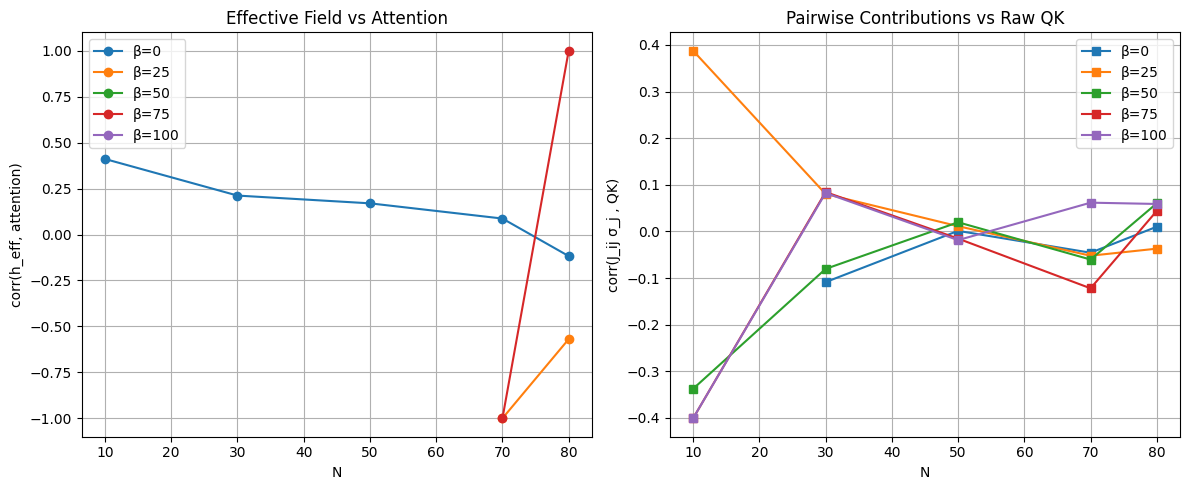

In [4]:
%pip install scipy.stats 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scipy.stats (from versions: none)
ERROR: No matching distribution found for scipy.stats
You should consider upgrading via the 'd:\venvs\torch_cuda\Scripts\python.exe -m pip install --upgrade pip' command.


Using device: cuda

===== N = 10 =====
  beta = 5
Spearman = -0.255743 | 
  beta = 10
Spearman = -0.199418 | 
  beta = 15
Spearman = 0.313501 | 
  beta = 19
Spearman = -0.743590 | 

===== N = 30 =====
  beta = 5
Spearman = 0.687543 | 
  beta = 10
Spearman = 0.627119 | 
  beta = 15
Spearman = -0.641750 | 
  beta = 19


C:\Users\Acer\AppData\Local\Temp\ipykernel_17644\842912002.py:164: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman, p_value = spearmanr(h_vals, qk_sum_vals)


Spearman = nan | 

===== N = 50 =====
  beta = 5
Spearman = -0.000656 | 
  beta = 10
Spearman = -0.286846 | 
  beta = 15
Spearman = 0.199818 | 
  beta = 19
Spearman = nan | 

===== N = 70 =====
  beta = 5
Spearman = 0.372398 | 
  beta = 10
Spearman = -0.580025 | 
  beta = 15
Spearman = 1.000000 | 
  beta = 19
Spearman = nan | 

===== N = 90 =====
  beta = 5
Spearman = 0.573848 | 
  beta = 10
Spearman = 0.993169 | 
  beta = 15
Spearman = -0.875137 | 
  beta = 19
Spearman = -0.015773 | 
min(h) = -1.0621371269226074 max(h) = -0.7963289618492126 std(h) = 0.07932101055156646


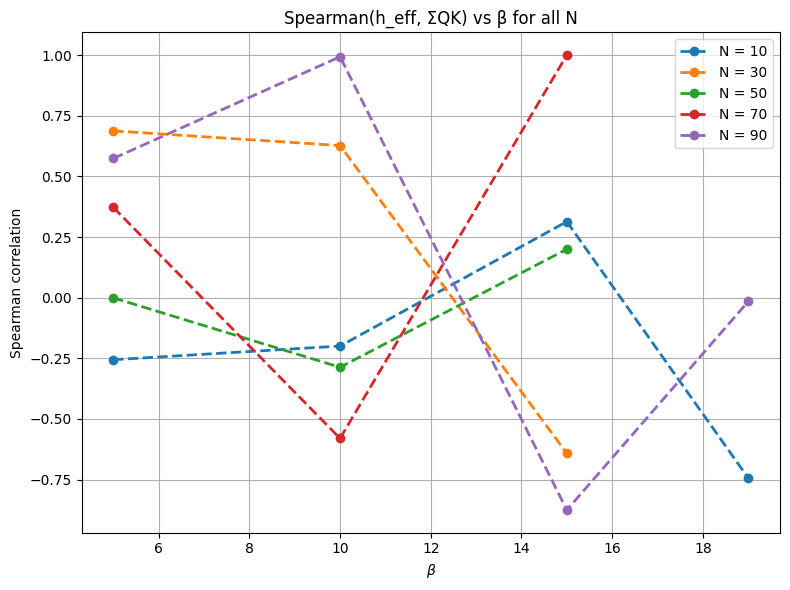